In [1]:
# import some library
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
# read data
df = pd.read_csv('../data/feature_importance_pos.csv', index_col=0)

# divide objective and target
objective = df.Subclass
le = preprocessing.LabelEncoder()
objective = le.fit_transform(objective)
features = df.drop('Subclass', axis=1)

# train test split
random_state=np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    objective,
    test_size=0.2
)

In [3]:
# gridsearch
def grid_search_():
    t = []
    for i in [5, 6]: # max_depth:
        for p in [4, 5]: # min_child_weight
            for l in [0]: # gamma
                for m in [1]: # subsample
                    for b in [1]: # colsample_bytree
                        f =[]
                        gbm = xgb.XGBClassifier(
                            device='gpu',
                            gpu_id=1,
                            max_depth=i,
                            updater='grow_gpu_hist',
                            objective='multi:softmax',
                            min_child_weight=p,
                            gamma=l,
                            subsample=m,
                            colsample_bytree=b,
                            n_estimators=100, 
            #                 learning_rate=0.01
                        ).fit(X_train, y_train)

                        t.append([
                            gbm.score(X_test, y_test),
                            i, p, l, m, b
                        ])

                        print(gbm.score(X_test, y_test))
                        
    t = pd.DataFrame(t, columns=[
        'Accuracy',
        'max_depth',
        'min_child_weight',
        'gamma',
        'subsample',
        'colsample_bytree'
    ]).sort_values('Accuracy', ascending=False)
    
    return t

In [4]:
# 
gbm = xgb.XGBClassifier(
    device='gpu',
    gpu_id=1,
    max_depth=5,
    updater='grow_gpu_hist',
    objective='multi:softmax',
    min_child_weight=4,
    gamma=0,
    subsample=1,
    colsample_bytree=1,
    n_estimators=100,
).fit(X_train, y_train)

In [5]:
pickle.dump(gbm, open('../model/XGB_best_params.sav', 'wb'))

In [6]:
# plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=16)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

/home/yoshitaka-i/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


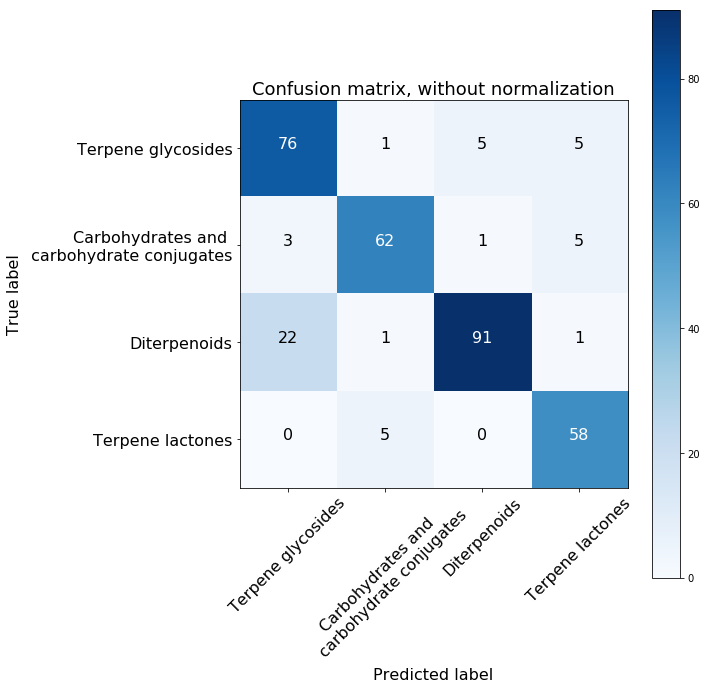

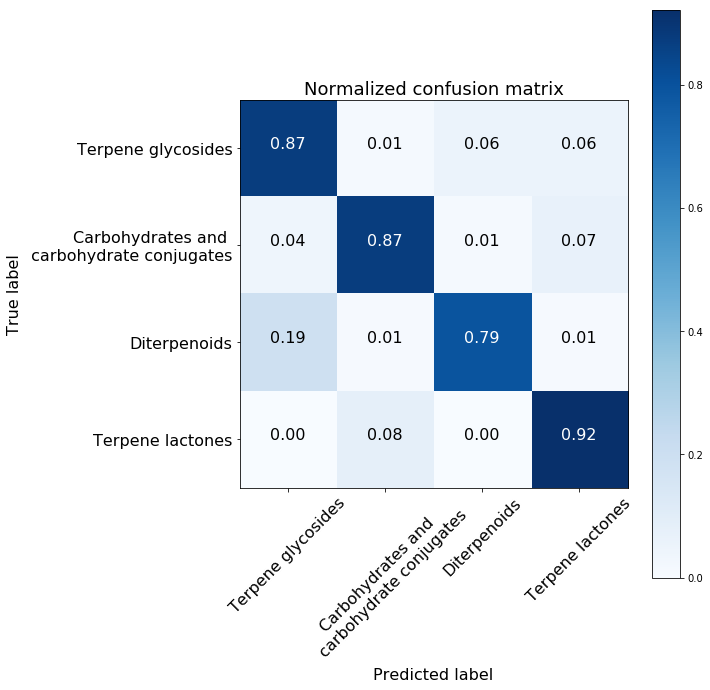

In [7]:
# set name list
class_names = list(df.Subclass.value_counts().index)
class_names[1] = 'Carbohydrates and \n carbohydrate conjugates'

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, gbm.predict(X_test))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()